# Preparation and Import Library

In [19]:
pip install gradio pandas scikit-learn sentence-transformers Faker fuzzywuzzy python-Levenshtein gdown

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
import gradio as gr
import gdown

# Preparing Data

In [21]:
def load_dataset(gdrive_url="https://drive.google.com/file/d/1NdUEHFtHcTXH1ujALELQAD1ueYhQ814v/view?usp=drive_link"):
    """
    Downloads and loads the static dataset from a Google Drive URL.
    """
    print(f"--- Part 1: Loading Static Dataset from Google Drive ---")
    try:
        file_id = gdrive_url.split('/')[-2]
        
        download_url = f'https://drive.google.com/uc?id={file_id}'
        
        output_filename = 'static_lead_dataset.csv'
        gdown.download(download_url, output_filename, quiet=False)
        
        df = pd.read_csv(output_filename)
        print(f"Dataset successfully loaded with {len(df)} rows.\n")
        return df
        
    except Exception as e:
        print(f"Error: Failed to download or load the dataset. {e}")
        return None

def rank_leads_by_similarity(prospects_df, pipeline):
    if len(prospects_df) < 2:
        return prospects_df
    num_to_sample = min(2, len(prospects_df))
    user_selected_icp_names = prospects_df.head(num_to_sample)['company_name'].tolist()
    text_vectors = pipeline['sbert'].encode(prospects_df['description'].tolist())
    num_vectors = pipeline['scaler'].transform(prospects_df[['employee_count', 'annual_revenue_millions_usd']])
    all_vectors = np.hstack((num_vectors, text_vectors))
    icp_indices = prospects_df[prospects_df['company_name'].isin(user_selected_icp_names)].index.tolist()
    original_to_array_indices = {original_idx: array_idx for array_idx, original_idx in enumerate(prospects_df.index)}
    icp_array_indices = [original_to_array_indices[idx] for idx in icp_indices]
    icp_vectors = all_vectors[icp_array_indices]
    icp_target_vector = np.mean(icp_vectors, axis=0).reshape(1, -1)
    similarity_scores = cosine_similarity(icp_target_vector, all_vectors)
    ranked_df = prospects_df.copy()
    ranked_df['icp_score'] = similarity_scores[0]
    return ranked_df.sort_values(by='icp_score', ascending=False).reset_index(drop=True)

In [22]:
print("Performing model setup... Please wait.")
full_dataset = load_dataset()

Performing model setup... Please wait.
--- Part 1: Loading Static Dataset from Google Drive ---


Downloading...
From: https://drive.google.com/uc?id=1NdUEHFtHcTXH1ujALELQAD1ueYhQ814v
To: /kaggle/working/static_lead_dataset.csv
100%|██████████| 1.10M/1.10M [00:00<00:00, 127MB/s]

Dataset successfully loaded with 10000 rows.



In [23]:
full_dataset.head(10)

,company_name,industry,employee_count,annual_revenue_millions_usd,description,is_good_lead
0,"Medina, Summers and Higgins LLC",Media & Entertainment,400,172,A Media & Entertainment company focused on whi...,0
1,Davis PLC LLC,Food & Beverage,401,59,A Food & Beverage company focused on redefine ...,1
2,Perez Group LLC,Retail,66,82,A Retail company focused on transform out-of-t...,1
3,"Warren, Melendez and Garcia Group",Automotive,5,1,A Automotive company focused on architect exte...,0
4,Rodriguez Group LLC,Telecommunications,811,91,A Telecommunications company focused on aggreg...,0
5,"Rogers, White and Cantu LLC",Cosmetics,7,3,A Cosmetics company focused on benchmark turn-...,0
6,"Russo, Watson and Ramirez Solutions",Biotechnology,606,165,A Biotechnology company focused on aggregate d...,1
7,Joyce Ltd LLC,Retail,411,107,A Retail company focused on syndicate synergis...,1
8,Ross-Mason LLC,Cybersecurity,603,64,A Cybersecurity company focused on e-enable ri...,1
9,Gaines-Jimenez LLC,Fashion & Apparel,104,54,A Fashion & Apparel company focused on synthes...,0


# EDA

Performing Exploratory Data Analysis (EDA)
Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   company_name                 10000 non-null  object
 1   industry                     10000 non-null  object
 2   employee_count               10000 non-null  int64 
 3   annual_revenue_millions_usd  10000 non-null  int64 
 4   description                  10000 non-null  object
 5   is_good_lead                 10000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 468.9+ KB

Descriptive Statistics for Numerical Features:
       employee_count  annual_revenue_millions_usd  is_good_lead
count    10000.000000                 10000.000000  10000.000000
mean       355.952000                    71.369800      0.569700
std        331.322532                    65.644005      0.495143
min          5

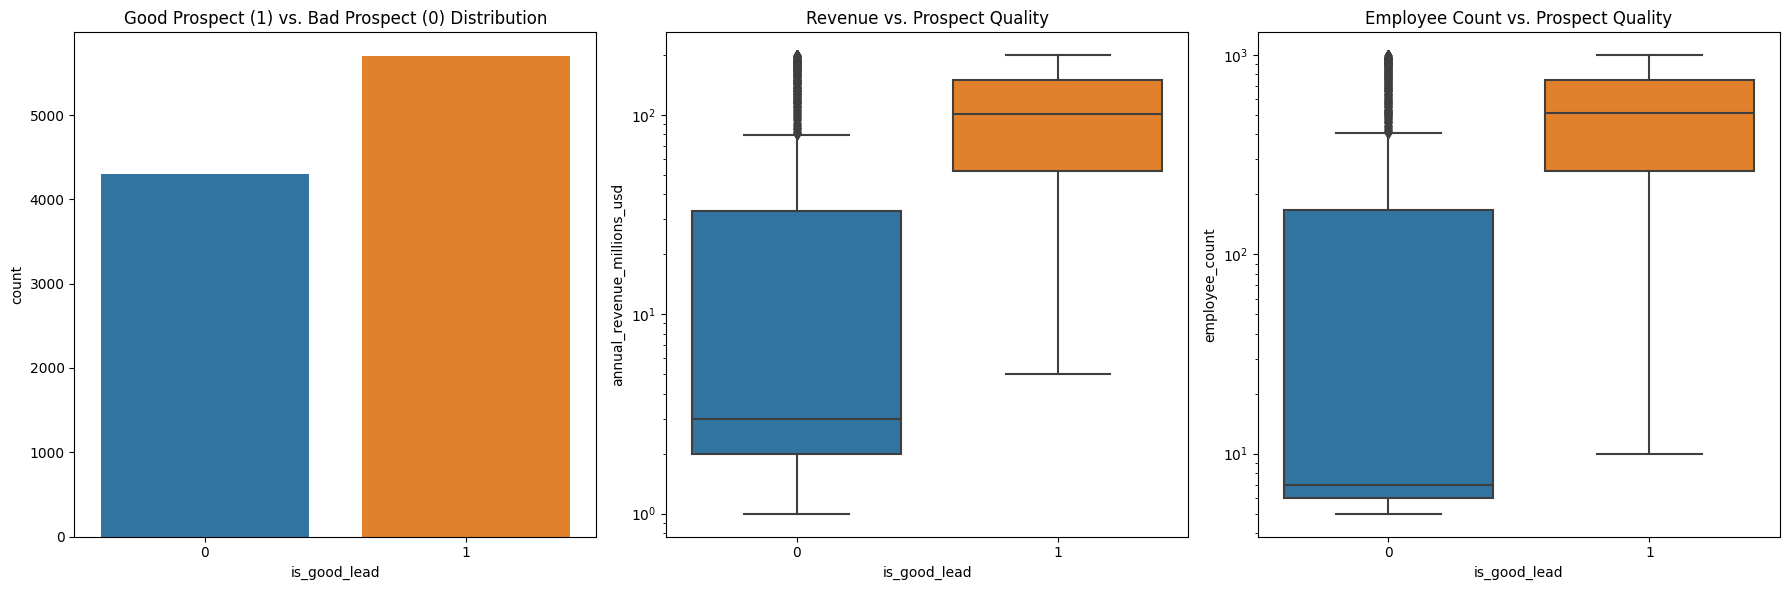

In [24]:
print("Performing Exploratory Data Analysis (EDA)")
print("Basic Dataset Info:")
full_dataset.info()

print("\nDescriptive Statistics for Numerical Features:")
print(full_dataset.describe())

print("\nTarget Class Distribution ('is_good_lead'):")
print(full_dataset['is_good_lead'].value_counts(normalize=True))

# Visualizations
plt.figure(figsize=(18, 6))

# Class Distribution
plt.subplot(1, 3, 1)
sns.countplot(data=full_dataset, x='is_good_lead')
plt.title('Good Prospect (1) vs. Bad Prospect (0) Distribution')

# Revenue Distribution vs. Lead Quality
plt.subplot(1, 3, 2)
sns.boxplot(data=full_dataset, x='is_good_lead', y='annual_revenue_millions_usd')
plt.title('Revenue vs. Prospect Quality')
plt.yscale('log')

# Employee Count Distribution vs. Lead Quality
plt.subplot(1, 3, 3)
sns.boxplot(data=full_dataset, x='is_good_lead', y='employee_count')
plt.title('Employee Count vs. Prospect Quality')
plt.yscale('log') 

plt.tight_layout()
plt.show()

# Model Training

In [25]:
# Train First Part Model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
text_features = sbert_model.encode(full_dataset['description'])
numerical_features_df = full_dataset[['employee_count', 'annual_revenue_millions_usd']]
scaler = MinMaxScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_df)
X = np.hstack((numerical_features_scaled, text_features))
y = full_dataset['is_good_lead']
classifier_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
classifier_model.fit(X, y)

# Save Component
PIPELINE = {'sbert': sbert_model, 'scaler': scaler, 'model': classifier_model}
print("Setup complete. Gradio app is starting...")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Setup complete. Gradio app is starting...


# Model Evaluation

Re-training model on the training set for fair evaluation...
Model for evaluation has been trained.

--- Stage 1 Model Evaluation Report ---
               precision    recall  f1-score   support

 Bad Prospect       1.00      0.93      0.96       861
Good Prospect       0.95      1.00      0.97      1139

     accuracy                           0.97      2000
    macro avg       0.97      0.96      0.97      2000
 weighted avg       0.97      0.97      0.97      2000

Overall Model Accuracy: 96.85%

--- Confusion Matrix ---


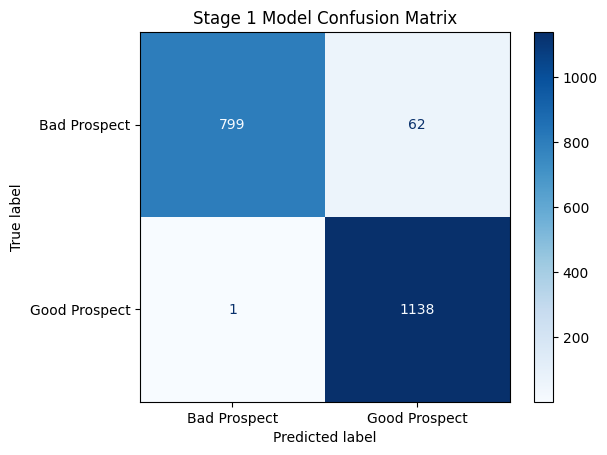

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Prepare Data for Evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       
    random_state=42, 
    stratify=y         
)

# Re-train the Model on the Training Set Only
print("Re-training model on the training set for fair evaluation...")
eval_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
eval_model.fit(X_train, y_train)
print("Model for evaluation has been trained.")

# Make Predictions on the Test Set
y_pred = eval_model.predict(X_test)

# Classification Metrics Report
print("\n--- Stage 1 Model Evaluation Report ---")

print(classification_report(y_test, y_pred, target_names=['Bad Prospect', 'Good Prospect']))

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Model Accuracy: {accuracy:.2%}")

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad Prospect', 'Good Prospect'])
disp.plot(cmap='Blues')
plt.title('Stage 1 Model Confusion Matrix')
plt.show()

# Input Output Program

In [27]:
def find_leads(icp_industries_str):
    """
    The main function called by Gradio.
    Takes user input, runs the hybrid model, and returns a Markdown table.
    """
    if not icp_industries_str:
        return "Please enter at least one industry to begin."

    # Process user input into a list
    user_target_industries = [item.strip() for item in icp_industries_str.split(',')]
    
    # Simulate Scraping based on user input with fuzzy matching
    scraped_leads_df = full_dataset.copy()
    
    matched_industries = []
    for user_industry in user_target_industries:
        best_match, score = process.extractOne(user_industry, full_dataset['industry'].unique())
        if score >= 80:
            matched_industries.append(best_match)
    
    if not matched_industries:
        return f"Could not find any matching industries for: `{icp_industries_str}`"
    
    scraped_leads_df = scraped_leads_df[scraped_leads_df['industry'].isin(matched_industries)]

    if scraped_leads_df.empty:
        return f"No companies found for industries: `{', '.join(matched_industries)}`"

    # Stage 1: Filter with the classification model
    vectors_scraped = np.hstack((
        PIPELINE['scaler'].transform(scraped_leads_df[['employee_count', 'annual_revenue_millions_usd']]),
        PIPELINE['sbert'].encode(scraped_leads_df['description'].tolist())
    ))
    initial_predictions = PIPELINE['model'].predict(vectors_scraped)
    scraped_leads_df['initial_filter_result'] = initial_predictions
    
    filtered_leads_df = scraped_leads_df[scraped_leads_df['initial_filter_result'] == 1].copy().reset_index(drop=True)
    
    if filtered_leads_df.empty:
        return "After the initial AI filter, no relevant prospects were found. Try a broader search."

    # Stage 2: Personalized ranking
    final_ranked_prospects = rank_leads_by_similarity(filtered_leads_df, PIPELINE)
    
    # Return the final result as a Markdown formatted table
    return final_ranked_prospects[['company_name', 'industry', 'employee_count', 'annual_revenue_millions_usd', 'description', 'icp_score']].to_markdown(index=False)

# User Interface

In [28]:
saas_theme = gr.themes.Base(
    primary_hue=gr.themes.colors.blue,
    secondary_hue=gr.themes.colors.blue,
    neutral_hue=gr.themes.colors.gray,
    font=[gr.themes.GoogleFont("Inter"), "ui-sans-serif", "system-ui", "sans-serif"],
).set(
    body_background_fill="#0A0F1E",
    body_text_color="#FFFFFF",
    block_background_fill="#1C2A4A",
    block_border_width="0px",
    block_radius="8px",
    block_label_text_color="#FFFFFF",
    input_background_fill="#2A3B5A",
    button_primary_background_fill="#3B82F6",
    button_primary_text_color="#FFFFFF",
    body_background_fill_dark="#0A0F1E",
    body_text_color_dark="#FFFFFF",
    background_fill_primary="#1C2A4A",
    background_fill_primary_dark="#1C2A4A",
    block_background_fill_dark="#1C2A4A",
    border_color_accent="#1C2A4A",
    border_color_accent_dark="#1C2A4A",
    border_color_primary="#1C2A4A",
    border_color_primary_dark="#1C2A4A",
    color_accent_soft_dark="transparent",
    body_text_weight="400"
)

with gr.Blocks(theme=saas_theme) as demo:
    gr.HTML("""
    <div style="text-align: center; max-width: 800px; margin: 0 auto;">
        <h1 style="font-size: 3em; color: #FFFFFF; font-weight: 700;">
            Transform Your Lead Generation
        </h1>
        <p style="font-size: 1.2em; color: #A0AEC0; margin-bottom: 20px;">
            Enter your target industries to find and rank potential leads using our AI-powered model.
        </p>
    </div>
    """)
    
    with gr.Row():
        industry_input = gr.Textbox(
            label="Target Industries", 
            placeholder="e.g., SaaS, Fintech, AI (separate with comma)",
            scale=3
        )
        submit_button = gr.Button("Find Leads", variant="primary", scale=1)
        
    output_markdown = gr.Markdown(label="Ranked Leads")
    
    submit_button.click(
        fn=find_leads, 
        inputs=industry_input,
        outputs=output_markdown 
    )

if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1af97f23acd8f94cbd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]